# Customer Complaints Classification

## Objective

Classify consumers' complaints into the product category it belongs to using the description of the complaint.

## Content

1. Exploratory Data Analysis

2. Text preprocessing

3. Complaint Classifier Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import os
from textblob import TextBlob
from nltk.stem import PorterStemmer
from textblob import Word
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import sklearn.feature_extraction.text as text
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from io import StringIO
import seaborn as sns

In [2]:
data = pd.read_csv("D:\Projects\Consumer_Complaints.csv",encoding='latin-1')
data.tail()

C:\Users\ASUS\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (5,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
555952,07/01/2014,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,Bank of America,NaN,NaN,NaN,NaN,Referral,07/07/2014,Closed with explanation,Yes,No,919529
555953,07/01/2014,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Residential Credit Solutions,NaN,NaN,"Older American, Servicemember",NaN,Referral,07/23/2014,Closed with explanation,No,No,918447
555954,07/10/2012,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,BB&T Financial,NaN,NaN,NaN,NaN,Phone,11/18/2013,Closed with explanation,Yes,No,114550
555955,04/14/2015,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,NaN,NaN,Global Recovery Group,NaN,NaN,NaN,NaN,Phone,04/14/2015,Untimely response,No,No,1329963
555956,08/14/2014,Debt collection,I do not know,Cont'd attempts collect debt not owed,Debt is not mine,NaN,NaN,"CCS Financial Services, Inc.",NaN,NaN,NaN,NaN,Phone,08/18/2014,Closed with explanation,Yes,No,984116


In [3]:
data.dtypes

date_received                   object
product                         object
sub_product                     object
issue                           object
sub_issue                       object
consumer_complaint_narrative    object
company_public_response         object
company                         object
state                           object
zipcode                         object
tags                            object
consumer_consent_provided       object
submitted_via                   object
date_sent_to_company            object
company_response_to_consumer    object
timely_response                 object
consumer_disputed?              object
complaint_id                     int64
dtype: object

In [4]:
# Selecting required columns and rows
data = data[['product', 'consumer_complaint_narrative']]
data = data[pd.notnull(data['consumer_complaint_narrative'])]

In [5]:
# Factorizing the category column
data['category_id'] = data['product'].factorize()[0]
data['category_id'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [6]:
#  create dictionaries
category_id_data = data[['product', 'category_id']].drop_duplicates().sort_values('category_id')
category_id_data

,product,category_id
190126,Debt collection,0
190135,Consumer Loan,1
190155,Mortgage,2
190263,Credit card,3
191477,Credit reporting,4
191554,Student loan,5
192044,Bank account or service,6
192412,Payday loan,7
195610,Money transfers,8
196507,Other financial service,9


In [7]:
#  create dictionaries
category_to_id = dict(category_id_data.values)
category_to_id

{'Debt collection': 0,
 'Consumer Loan': 1,
 'Mortgage': 2,
 'Credit card': 3,
 'Credit reporting': 4,
 'Student loan': 5,
 'Bank account or service': 6,
 'Payday loan': 7,
 'Money transfers': 8,
 'Other financial service': 9,
 'Prepaid card': 10}

In [8]:
#  create dictionaries
id_to_category = dict(category_id_data[['category_id', 'product']].values)
id_to_category

{0: 'Debt collection',
 1: 'Consumer Loan',
 2: 'Mortgage',
 3: 'Credit card',
 4: 'Credit reporting',
 5: 'Student loan',
 6: 'Bank account or service',
 7: 'Payday loan',
 8: 'Money transfers',
 9: 'Other financial service',
 10: 'Prepaid card'}

In [9]:
data.tail()

,product,consumer_complaint_narrative,category_id
553084,Credit reporting,"XXXX XXXX is reporting incorrectly, payments h...",4
553085,Credit reporting,Reflecting incorrect payment status. Have been...,4
553086,Payday loan,I have been paying {$180.00} a month through d...,7
553090,Mortgage,I recently became aware that Amerisave Mortgag...,2
553096,Mortgage,Bank of America has demonstrated an on-going l...,2


In [10]:
# Check the distribution of complaints by category
data.groupby('product').consumer_complaint_narrative.count()

product
Bank account or service     5711
Consumer Loan               3678
Credit card                 7929
Credit reporting           12526
Debt collection            17552
Money transfers              666
Mortgage                   14919
Other financial service      110
Payday loan                  726
Prepaid card                 861
Student loan                2128
Name: consumer_complaint_narrative, dtype: int64

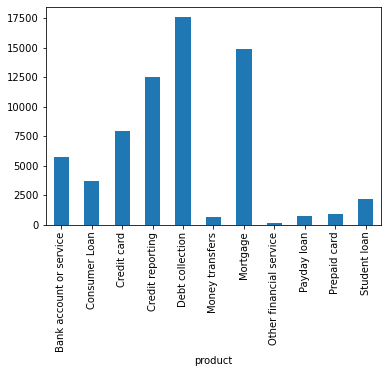

In [11]:
# plot distribution
data.groupby('product').consumer_complaint_narrative.count().plot.bar()
plt.show()

## Text Preprocessing

In [12]:
from nltk.corpus import stopwords
from textblob import TextBlob
from textblob import Word

In [14]:
# Lower casing and removing punctuations
data['consumer_complaint_narrative'] = data['consumer_complaint_narrative'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data['consumer_complaint_narrative'] = data['consumer_complaint_narrative'].str.replace('[^\w\s]',"")
data['consumer_complaint_narrative'].head()

C:\Users\ASUS\AppData\Local\Temp/ipykernel_24600/600231852.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  data['consumer_complaint_narrative'] = data['consumer_complaint_narrative'].str.replace('[^\w\s]',"")


190126    xxxx has claimed i owe them 2700 for xxxx year...
190135    due to inconsistencies in the amount owed that...
190155    in xxxxxxxx my wages that i earned at my job d...
190207    i have an open and current mortgage with chase...
190208    xxxx was submitted xxxxxxxx at the time i subm...
Name: consumer_complaint_narrative, dtype: object

In [15]:
# Removal of stop words
stop = set(stopwords.words('english'))
data['consumer_complaint_narrative'] = data['consumer_complaint_narrative'].apply(lambda x: " ".join([x for x in x.split() if x not in stop]))
data['consumer_complaint_narrative'].head()

190126    xxxx claimed owe 2700 xxxx years despite proof...
190135    due inconsistencies amount owed told bank amou...
190155    xxxxxxxx wages earned job decreased almost hal...
190207    open current mortgage chase bank xxxx chase re...
190208    xxxx submitted xxxxxxxx time submitted complai...
Name: consumer_complaint_narrative, dtype: object

In [17]:
# Lemmatization
data['consumer_complaint_narrative'] = data['consumer_complaint_narrative'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
data['consumer_complaint_narrative'].head()

190126    xxxx claimed owe 2700 xxxx year despite proof ...
190135    due inconsistency amount owed told bank amount...
190155    xxxxxxxx wage earned job decreased almost half...
190207    open current mortgage chase bank xxxx chase re...
190208    xxxx submitted xxxxxxxx time submitted complai...
Name: consumer_complaint_narrative, dtype: object

## Complaint Classifier

In [18]:
# Split the data into train and validation:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(data['consumer_complaint_narrative'], data['product'])

In [19]:
#  Feature engineering using TF-IDF
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

tfidf_vect = TfidfVectorizer(analyzer='word', stop_words='english', ngram_range=(1, 2), token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(data['consumer_complaint_narrative'])

xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

In [20]:
#  Model building and evaluation
LogisticRegression = linear_model.LogisticRegression(max_iter=500).fit(xtrain_tfidf, train_y)

# Checking accuracy
accuracy = metrics.accuracy_score(LogisticRegression.predict(xvalid_tfidf),valid_y)
print ("Accuracy: ", accuracy)

Accuracy:  0.8510956771644115


In [21]:
#  Model building and evaluation
from sklearn.svm import LinearSVC
clf = LinearSVC()

LinearSVC = clf.fit(xtrain_tfidf, train_y)

# Checking accuracy
accuracy = metrics.accuracy_score(LinearSVC.predict(xvalid_tfidf),valid_y)
print ("Accuracy: ", accuracy)

Accuracy:  0.8465453239133038


In [22]:
#  Model building and evaluation
from sklearn.ensemble import RandomForestClassifier

RandomForestClassifier = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0).fit(xtrain_tfidf, train_y)

# Checking accuracy
accuracy = metrics.accuracy_score(RandomForestClassifier.predict(xvalid_tfidf),valid_y)
print ("Accuracy: ", accuracy)

Accuracy:  0.47251826128607355


In [23]:
#  Model building and evaluation
from sklearn.naive_bayes import MultinomialNB

MultinomialNB = MultinomialNB().fit(xtrain_tfidf, train_y)

# Checking accuracy
accuracy = metrics.accuracy_score(MultinomialNB.predict(xvalid_tfidf),valid_y)
print ("Accuracy: ", accuracy)

Accuracy:  0.8118788169081547


Note : Logistic Regression perform better than the other classifiers, with accuracy around 85.1%.

In [24]:
# Classification report
print(metrics.classification_report(valid_y, LogisticRegression.predict(xvalid_tfidf),target_names=data['product'].unique()))

                         precision    recall  f1-score   support

        Debt collection       0.83      0.81      0.82      1467
          Consumer Loan       0.77      0.61      0.68       878
               Mortgage       0.81      0.82      0.82      1941
            Credit card       0.86      0.85      0.86      3159
       Credit reporting       0.82      0.89      0.86      4371
           Student loan       0.76      0.48      0.59       176
Bank account or service       0.93      0.95      0.94      3793
            Payday loan       0.00      0.00      0.00        25
        Money transfers       0.68      0.37      0.47       156
Other financial service       0.80      0.60      0.69       199
           Prepaid card       0.91      0.79      0.85       537

               accuracy                           0.85     16702
              macro avg       0.74      0.65      0.69     16702
           weighted avg       0.85      0.85      0.85     16702



C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


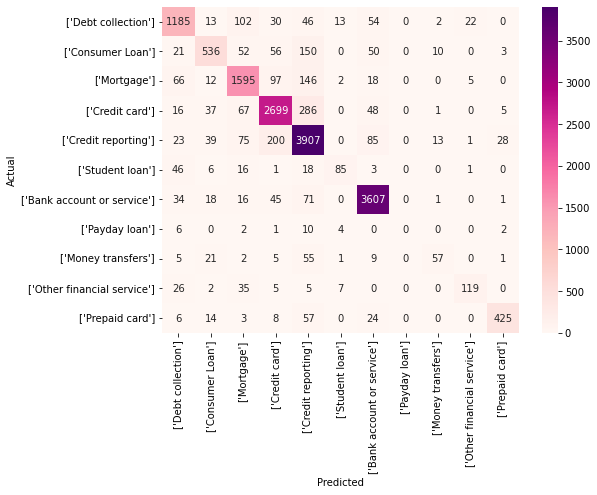

In [25]:
#confusion matrix
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(valid_y, LogisticRegression.predict(xvalid_tfidf))

# Vizualizing confusion matrix
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="RdPu", 
            xticklabels=category_id_data[['product']].values, 
            yticklabels=category_id_data[['product']].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [26]:
# Prediction example
texts =  ["This company refuses to provide me verification and validation of debt"+ "per my right under the FDCPA. I do not believe this debt is mine."]
text_features = tfidf_vect.transform(texts)
predictions = LogisticRegression.predict(text_features)
print(texts)
print("  - Predicted as: '{}'".format(id_to_category[predictions[0]]))

['This company refuses to provide me verification and validation of debtper my right under the FDCPA. I do not believe this debt is mine.']
  - Predicted as: 'Credit reporting'


In [27]:
# misclassifications
from IPython.display import display

for predicted in category_id_data.category_id:
    for actual in category_id_data.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 10:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            # display(data.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 'Consumer_complaint_narrative']])
            print('')

'Consumer Loan' predicted as 'Debt collection' : 21 examples.

'Mortgage' predicted as 'Debt collection' : 66 examples.

'Credit card' predicted as 'Debt collection' : 16 examples.

'Credit reporting' predicted as 'Debt collection' : 23 examples.

'Student loan' predicted as 'Debt collection' : 46 examples.

'Bank account or service' predicted as 'Debt collection' : 34 examples.

'Other financial service' predicted as 'Debt collection' : 26 examples.

'Debt collection' predicted as 'Consumer Loan' : 13 examples.

'Mortgage' predicted as 'Consumer Loan' : 12 examples.

'Credit card' predicted as 'Consumer Loan' : 37 examples.

'Credit reporting' predicted as 'Consumer Loan' : 39 examples.

'Bank account or service' predicted as 'Consumer Loan' : 18 examples.

'Money transfers' predicted as 'Consumer Loan' : 21 examples.

'Prepaid card' predicted as 'Consumer Loan' : 14 examples.

'Debt collection' predicted as 'Mortgage' : 102 examples.

'Consumer Loan' predicted as 'Mortgage' : 52 exam